# HyPro Preprocessing for CHTC

<hr>

In [1]:
import json
import logging

from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
from enspec.config import GLOBUS_ENDPOINTS as endpoints
from enspec.database import EnSpecDB
from enspec.display.table import pretty_print
from enspec.filesystem.transfer import TransferOptions, HyProTransferSession
from enspec.processing.utilities.config import make_config
from enspec.processing.utilities.pixel_size import estimate_pixel_sizes, update_metadata, pixel_size_histogram
from enspec.processing.utilities.prepare_hyspex import generate_chtc_joblist, select_sessions, prepare_hyspex_inputs, prioritize_sessions

<hr>

In [3]:
db = EnSpecDB()

In [4]:
logger = logging.getLogger('enspec')
handler = logging.StreamHandler()
formatter = logging.Formatter(
    fmt='%(asctime)s ::: %(message)s',
    datefmt='%Y-%m-%dT%H:%M:%S'
)

logger.setLevel(logging.DEBUG)
handler.setFormatter(formatter)
logger.addHandler(handler)

<br>

# Processing

<hr>

## Set up variables & paths

In [5]:
PROJECT, SITE, YEAR = 'BHKI', 'BHKI', 2024

VDATUM = 'geoid'
# VDATUM = 'ellipsoid'

In [6]:
# Username
USER = 'bheberlein'

# Farnsworth drive mount point
ENSPEC = Path('Z:/')

# CHTC group Staging space
STAGING = Path('/staging/groups/townsend_airborne')

In [7]:
# Top-level processing directory
PROCESSING = ENSPEC/f'users/{USER}/processing/{YEAR}'
# Packaged job inputs will go here
OUTPUT = PROCESSING/PROJECT/'raw-inputs'
OUTPUT.mkdir(exist_ok=True, parents=True)

## Select images to process

#### Examples

**1). Find Hancock images from 2023:**
```python
sessions, images = select_sessions(session='HARS', year=2023, comparison='startswith', return_images=True)
```


**2). Find WisAsp images from 2021 & 2022:**
```python
sessions, images = select_sessions(session=['GENO', 'COMP', 'ASPEN', 'Asp'], year=[2021, 2022], comparison='contains', return_images=True)
```


**3). Find LakeView images:**
```python
sessions, images = select_sessions(session=['LAKE', 'POND'], year=[2023, 2024], return_images=True)
```


**4). Find images on a specific date:**
```python
# Extract all flights on a specific day
flights = db.Flights.find_date('date', pd.Timestamp(datetime(year=2022, month=6, day=17)))
# Query sessions from subset of flights
sessions, images = select_sessions(flights=flights, session='CCESR', comparison='contains', return_images=True)
```

In [8]:
sessions, images = select_sessions(session=['BHI', 'BHKI'], year=list(range(2019, 2025)), return_images=True)
sessions_ = sessions

In [9]:
print(f'{len(images.session_id.unique())} sessions found.')
print(f'{len(images.line_id.unique())} flightlines found.')

13 sessions found.
138 flightlines found.


### Check inputs

In [10]:
# Optionally, you can inspect which IMAGING SESSIONS have been selected for processing
pretty_print(sessions.drop(columns=['notes_x', 'notes_y']))

,flight_id,date,aircraft,pilot,operator,battery,departing_airfield,landing_airfield,time_engine_on,time_liftoff,time_touchdown,time_engine_off,voltage_start,voltage_end,tachometer_start,tachometer_end,hobbs_start,hobbs_end,session_id,flightplan_id,session_name,target_altitude_ftAGL,target_altitude_ftMSL,target_groundspeed_kn,target_pixel_size_m,figure_eight,time_start,time_end,line_count
274,93870097-7919-4d1c-a3ad-4863d8373b4f,2021-06-16 00:00:00,N182NR,Mike Kakuska,Brendan Heberlein,nan,nan,nan,nan,2021-06-16 10:54:00,2021-06-16 14:40:00,nan,nan,nan,8271.900000,8275.500000,nan,nan,35f23fa9-d912-4a4b-a90b-4dc2a991526d,nan,BHI,nan,nan,nan,nan,Yes,2021-06-16 12:52:00,nan,20.000000
334,ee1572dc-7cc8-4b73-9600-0d6a813d8b3a,2021-07-19 00:00:00,N182NR,Brian Ross,Brendan Heberlein,nan,nan,nan,nan,2021-07-19 10:01:00,2021-07-19 12:14:00,nan,nan,nan,8325.000000,8327.200000,249.100000,251.500000,38289521-19d0-4167-9a5c-698a37a6d38e,nan,BHI,nan,nan,nan,nan,nan,nan,nan,3.000000
414,94e11f3b-b5ee-4be9-acae-0fa9f92dc094,2021-09-23 00:00:00,N182NR,Mike Kakuska,Brendan Heberlein,nan,nan,nan,nan,2021-09-23 11:25:00,2021-09-23 14:48:00,nan,nan,nan,8392.100000,8396.200000,321.600000,325.100000,ec791b6a-3763-4d0e-9cd0-c57dc112d194,nan,BHI,nan,nan,nan,nan,Yes,2021-09-23 12:14:00,2021-09-23 12:42:00,7.000000
463,9f24ee8f-3c66-429e-95fc-19f28214aa64,2022-06-09 00:00:00,N182NR,Mike Kakuska,Eliceo Ruiz,SN105969,MSN - Madison,MSN - Madison,nan,nan,2022-06-09 13:40:22,2022-06-09 13:40:28,26.800000,25.500000,8518.200000,8520.400000,459.900000,462.300000,bb720ff1-8d4d-4e67-8b6b-814b6fb846d9,nan,BHI,nan,nan,nan,nan,nan,nan,nan,10.000000
468,912041fc-570e-4ca4-9707-d64304a39f89,2022-06-14 00:00:00,N182NR,Mike Kakuska,Brendan Heberlein,SN105969,MSN - Madison,DLL - Baraboo-Dells,2022-06-14 11:01:39,2022-06-14 11:18:34,2022-06-14 13:17:03,2022-06-14 13:18:22,26.900000,25.800000,8520.400000,8522.800000,462.300000,464.600000,bb29e819-90de-4390-882f-71722950f8b0,nan,BHI,nan,nan,nan,nan,nan,nan,nan,3.000000
469,cc560a94-8d35-4f5c-a877-193fbb147fee,2022-06-14 00:00:00,N182NR,Mike Kakuska,Brendan Heberlein,SN105969,DLL - Baraboo-Dells,MSN - Madison,2022-06-14 13:25:34,2022-06-14 13:30:55,2022-06-14 14:34:46,2022-06-14 14:38:41,25.800000,25.700000,8522.800000,8523.700000,464.600000,465.800000,4f29a620-21cf-47c6-ae21-39529c50bce6,nan,BHI,nan,nan,nan,nan,nan,nan,nan,8.000000
553,f8f77144-18eb-424b-b392-2f7436099196,2022-08-02 00:00:00,N182NR,Mike Kakuska,Brendan Heberlein,SN105971,MSN - Madison,MSN - Madison,2022-08-02 10:09:27,2022-08-02 10:24:41,2022-08-02 13:10:18,2022-08-02 13:14:23,26.600000,25.800000,8579.700000,8582.600000,525.800000,528.800000,0986dd1f-45be-4e44-81c5-8347820da1e9,nan,BHKI,0.000000,2775.000000,90.000000,0.000000,False,2022-08-02 12:33:57,2022-08-02 12:48:48,7.000000
595,c2be0122-d75d-4884-95e3-cdb4aceb6ba5,2022-08-31 00:00:00,N182NR,Greg Marchel,Brendan Heberlein,SN105969,MSN - Madison,MSN - Madison,nan,2022-08-31 10:33:04,2022-08-31 14:07:18,2022-08-31 14:12:09,26.800000,25.500000,8611.900000,8615.400000,560.000000,563.700000,7d88edee-f518-4d7e-a4df-8987a97006b8,nan,BHKI,0.000000,2775.000000,90.000000,0.000000,False,nan,nan,10.000000
795,59ef9459-cabd-4ffe-9473-a2c873de4fbb,2024-05-03 00:00:00,Cessna N182NR,Mike Kakuska,Brendan Heberlein,SN105969,MSN - Madison,MSN - Madison,11:26:56,11:37:30,13:29:37,13:32:57,26.900000,0.000000,8866.100000,8868.000000,838.300000,840.400000,21561528-3a4e-47a6-8663-e9559369298b,nan,BHKI,1100.000000,2000.000000,95.000000,0.500000,True,12:04:33,12:27:04,12.000000
803,be2b1d0d-63ad-4cd3-909f-f60cad18e8b7,2024-05-10 00:00:00,Cessna N182NR,Mike Kakuska,Brendan Heberlein,SN105969,MSN - Madison,MSN - Madison,11:34:19,11:48:42,13:29:48,13:33:41,26.900000,26.000000,8869.500000,8871.300000,842.100000,844.000000,0c823066-ef95-44f5-a33f-d7248a8b9726,nan,BHKI,0.000000,2000.000000,100.000000,0.500000,True,12:17:01,12:39:03,12.000000


In [11]:
# Optionally, you can inspect which IMAGES have been selected for processing
pretty_print(images)

,session_id,session_name,line_id,line_number,image_id,filepath
0,35f23fa9-d912-4a4b-a90b-4dc2a991526d,BHI,37af2874-fb30-4105-babe-4c658f742ca0,1,609b89e4-b028-45a3-940a-8949bd8e0ec8,Z:/data/collection/airborne/raw/2021/20210616/BHI_20210616/BHI_20210616_01_SWIR_384_SN3142_FOVx2_raw.hyspex
1,35f23fa9-d912-4a4b-a90b-4dc2a991526d,BHI,37af2874-fb30-4105-babe-4c658f742ca0,1,9a28680f-c3ad-4ee4-9b97-d333d1995c4a,Z:/data/collection/airborne/raw/2021/20210616/BHI_20210616/BHI_20210616_01_VNIR_1800_SN00840_FOVx2_raw.hyspex
2,35f23fa9-d912-4a4b-a90b-4dc2a991526d,BHI,1184c8dd-aadc-4e0c-9c19-4255a2dd0268,2,db722f26-d396-48ad-80c1-3785fae45c1e,Z:/data/collection/airborne/raw/2021/20210616/BHI_20210616/BHI_20210616_02_SWIR_384_SN3142_FOVx2_raw.hyspex
3,35f23fa9-d912-4a4b-a90b-4dc2a991526d,BHI,1184c8dd-aadc-4e0c-9c19-4255a2dd0268,2,6003809d-ace9-4844-a85b-cb38c8652536,Z:/data/collection/airborne/raw/2021/20210616/BHI_20210616/BHI_20210616_02_VNIR_1800_SN00840_FOVx2_raw.hyspex
4,35f23fa9-d912-4a4b-a90b-4dc2a991526d,BHI,a0b12a72-d2f1-4846-82ea-927e7170f7d9,3,d41b78ac-bc45-4891-86ff-f1f4c999ddfc,Z:/data/collection/airborne/raw/2021/20210616/BHI_20210616/BHI_20210616_03_SWIR_384_SN3142_FOVx2_raw.hyspex
5,35f23fa9-d912-4a4b-a90b-4dc2a991526d,BHI,a0b12a72-d2f1-4846-82ea-927e7170f7d9,3,ea9285b0-73f7-4057-91e9-4d4d78027a2c,Z:/data/collection/airborne/raw/2021/20210616/BHI_20210616/BHI_20210616_03_VNIR_1800_SN00840_FOVx2_raw.hyspex
6,35f23fa9-d912-4a4b-a90b-4dc2a991526d,BHI,db0e7ffe-7fad-4a2f-b9e0-175ce9ffd397,4,5d26f1d9-4bc6-4822-a339-47a2c17bf6ec,Z:/data/collection/airborne/raw/2021/20210616/BHI_20210616/BHI_20210616_04_SWIR_384_SN3142_FOVx2_raw.hyspex
7,35f23fa9-d912-4a4b-a90b-4dc2a991526d,BHI,db0e7ffe-7fad-4a2f-b9e0-175ce9ffd397,4,31416008-e910-40a4-9c67-3f53d41e2d41,Z:/data/collection/airborne/raw/2021/20210616/BHI_20210616/BHI_20210616_04_VNIR_1800_SN00840_FOVx2_raw.hyspex
8,35f23fa9-d912-4a4b-a90b-4dc2a991526d,BHI,77a572a7-97a1-4be9-b915-350fc47cbbaa,5,05b7d83c-3d94-4fb6-9cc7-a2e7d5e3f633,Z:/data/collection/airborne/raw/2021/20210616/BHI_20210616/BHI_20210616_05_SWIR_384_SN3142_FOVx2_raw.hyspex
9,35f23fa9-d912-4a4b-a90b-4dc2a991526d,BHI,77a572a7-97a1-4be9-b915-350fc47cbbaa,5,4189e6a9-e3f0-484b-b5dd-90c569c982ea,Z:/data/collection/airborne/raw/2021/20210616/BHI_20210616/BHI_20210616_05_VNIR_1800_SN00840_FOVx2_raw.hyspex


### Set session priority *(optional)*


#### Examples

**Prioritize certain sessions for processing:**
```python
# Order image queue by site priority (put WHIT first)
sessions_ = prioritize_sessions(sessions, sessions.session_name.str.startswith('WHIT'))
```

<br>

## Check pixel sizes

<hr>

In [12]:
# You can check if the database has pixel sizes, but they may be absent
sessions.target_pixel_size_m

274    NaN
334    NaN
414    NaN
463    NaN
468    NaN
469    NaN
553    0.0
595    0.0
795    0.5
803    0.5
864    0.5
874    0.5
913    0.5
Name: target_pixel_size_m, dtype: float64

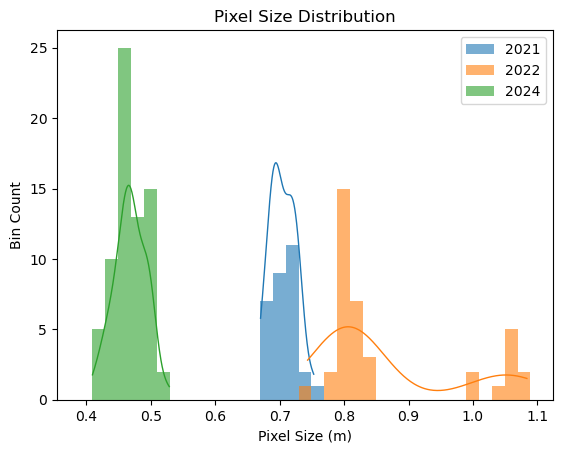

In [13]:
# Estimate image pixel sizes from sensor height above DEM
swir_images = estimate_pixel_sizes(images, local_prefix=ENSPEC.as_posix())
# Update dataframe with metadata (year, isodate, short_filepath)
update_metadata(swir_images, sessions, local_prefix=ENSPEC.as_posix())

# Plot a histogram of pixel sizes with kernel density
pixel_size_histogram(swir_images, by_year=True)

In [14]:
# You can use the dataframe to match individual images to their pixel size
pretty_print(swir_images[['year', 'isodate', 'pixel_size', 'short_filepath']])

,year,isodate,pixel_size,short_filepath
0,2021,2021-06-16,0.726200,2021/20210616/BHI_20210616/BHI_20210616_01_SWIR_384_SN3142_FOVx2_raw.hyspex
1,2021,2021-06-16,0.709883,2021/20210616/BHI_20210616/BHI_20210616_02_SWIR_384_SN3142_FOVx2_raw.hyspex
2,2021,2021-06-16,0.752823,2021/20210616/BHI_20210616/BHI_20210616_03_SWIR_384_SN3142_FOVx2_raw.hyspex
3,2021,2021-06-16,0.698897,2021/20210616/BHI_20210616/BHI_20210616_04_SWIR_384_SN3142_FOVx2_raw.hyspex
4,2021,2021-06-16,0.680739,2021/20210616/BHI_20210616/BHI_20210616_05_SWIR_384_SN3142_FOVx2_raw.hyspex
5,2021,2021-06-16,0.670273,2021/20210616/BHI_20210616/BHI_20210616_06_SWIR_384_SN3142_FOVx2_raw.hyspex
6,2021,2021-06-16,0.732958,2021/20210616/BHI_20210616/BHI_20210616_07_SWIR_384_SN3142_FOVx2_raw.hyspex
7,2021,2021-06-16,0.693754,2021/20210616/BHI_20210616/BHI_20210616_08_SWIR_384_SN3142_FOVx2_raw.hyspex
8,2021,2021-06-16,0.730270,2021/20210616/BHI_20210616/BHI_20210616_09_SWIR_384_SN3142_FOVx2_raw.hyspex
9,2021,2021-06-16,0.692523,2021/20210616/BHI_20210616/BHI_20210616_10_SWIR_384_SN3142_FOVx2_raw.hyspex


<br>

## Package raw inputs

<hr>

In [15]:
# options = TransferOptions()
# options = TransferOptions(force=True)

PACKAGING_START = datetime.now()

# Package up raw inputs for each flightline
prepare_hyspex_inputs(sessions_, OUTPUT, vdatum=VDATUM, compress=True)#, transfer=options)

PACKAGING_FINISH = datetime.now()

DURATION = (PACKAGING_FINISH - PACKAGING_START).total_seconds()

n_flightlines = len(images)//2
total_minutes = DURATION//60

print(f'Packaged raw inputs for {n_flightlines} flightlines in {total_minutes:.1f} minutes ({total_minutes/n_flightlines:.1f} min/line).')

2024-11-18T09:35:27 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240503 01
2024-11-18T09:35:27 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240503 01
2024-11-18T09:35:27 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T09:35:27 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T09:37:04 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T09:37:04 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T09:37:04 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T09:37:04 ::: "FLIGHT_20240503_01_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240503_01_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T09:37:04 ::: "FLIGHT_20240503_01_VNIR_1800_SN00840_FOVx

2024-11-18T10:33:37 ::: "FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T10:46:46 ::: "FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T10:46:46 ::: "FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240503_05_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T10:46:46 ::: "FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240503_05_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T10:46:46 ::: "FLIGHT_20240503_05_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240503_05_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T10:46:47 ::: Done.
2024-11-18T10:46:47 ::: Done.
2024-11-18T10:46:47 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240503 06
2024-11-18T10:46:47 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240503 06
2024-11-18T10:46:47 ::: "FLIGHT_20240503_06_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_06_SWIR_384_SN3142_FOVx

2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240503_10_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240503_10_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240503_10_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240503_10_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T11:39:16 ::: "FLIGHT_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T11:46:20 ::: "FLIGHT_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T11:46:20 ::: "FLIGHT_20240503_10_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240503_

2024-11-18T12:26:05 ::: "FLIGHT_20240510_03_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240510_02_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T12:26:06 ::: Done.
2024-11-18T12:26:06 ::: Done.
2024-11-18T12:26:06 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240510 03
2024-11-18T12:26:06 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240510 03
2024-11-18T12:26:06 ::: "FLIGHT_20240510_04_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_03_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T12:26:06 ::: "FLIGHT_20240510_04_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_03_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T12:27:51 ::: "FLIGHT_20240510_04_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240510_03_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T12:27:51 ::: "FLIGHT_20240510_04_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240510_03_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T12:27:51 ::: "FLIGHT_20240510_04_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240510_03_SWIR_384_SN3142_FOVx2_raw.txt"
20

2024-11-18T13:22:28 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T13:22:28 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T13:33:23 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T13:33:23 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T13:33:23 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T13:33:23 ::: "FLIGHT_20240510_08_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240510_07_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T13:33:24 ::: Done.
2024-11-18T13:33:24 ::: Done.
2024-11-18T13:33:24 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240510 08
2024-11-18T13:33:24 ::: Preparing .TAR.GZ archive for flightline:

2024-11-18T14:14:10 ::: "FLIGHT_20240510_13_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_12_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240510_12_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240510_12_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240510_12_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240510_12_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_12_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T14:15:46 ::: "FLIGHT_20240510_13_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240510_12_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T14:25:26 ::: "FLIGHT_20240510_13_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_2024051

2024-11-18T15:07:27 ::: "FLIGHT-2_20240726_10_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240726_04_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T15:07:27 ::: "FLIGHT-2_20240726_10_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240726_04_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T15:07:27 ::: "FLIGHT-2_20240726_10_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240726_04_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T15:07:27 ::: Done.
2024-11-18T15:07:27 ::: Done.
2024-11-18T15:07:27 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240726 05
2024-11-18T15:07:27 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240726 05
2024-11-18T15:07:27 ::: "FLIGHT-2_20240726_11_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240726_05_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T15:07:27 ::: "FLIGHT-2_20240726_11_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240726_05_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T15:09:17 ::: "FLIGHT-2_20240726_11_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240726_05_SWIR_384_SN31

2024-11-18T16:00:42 ::: "FLIGHT-2_20240726_15_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240726_09_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T16:00:42 ::: "FLIGHT-2_20240726_15_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240726_09_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T16:00:42 ::: "FLIGHT-2_20240726_15_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240726_09_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T16:00:42 ::: "FLIGHT-2_20240726_15_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240726_09_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T16:00:42 ::: "FLIGHT-2_20240726_15_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240726_09_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T16:09:35 ::: "FLIGHT-2_20240726_15_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240726_09_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T16:09:35 ::: "FLIGHT-2_20240726_15_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240726_09_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T16:09:35 ::: "FLIGHT-2_20240726_15_VNIR_1800_SN00840_FOVx2_raw.tx

2024-11-18T16:49:00 ::: "FLIGHT_20240819_09_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240819_01_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T16:49:00 ::: Done.
2024-11-18T16:49:00 ::: Done.
2024-11-18T16:49:01 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240819 02
2024-11-18T16:49:01 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240819 02
2024-11-18T16:49:01 ::: "FLIGHT_20240819_10_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_02_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T16:49:01 ::: "FLIGHT_20240819_10_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_02_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T16:50:30 ::: "FLIGHT_20240819_10_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_02_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T16:50:30 ::: "FLIGHT_20240819_10_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_02_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T16:50:30 ::: "FLIGHT_20240819_10_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240819_02_SWIR_384_SN3142_FOVx2_raw.txt"
20

2024-11-18T17:34:17 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T17:34:17 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T17:39:02 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T17:39:02 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T17:39:02 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T17:39:02 ::: "FLIGHT_20240819_14_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240819_06_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T17:39:02 ::: Done.
2024-11-18T17:39:02 ::: Done.
2024-11-18T17:39:03 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240819 07
2024-11-18T17:39:03 ::: Preparing .TAR.GZ archive for flightline:

2024-11-18T18:09:56 ::: "FLIGHT_20240819_19_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_11_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T18:11:17 ::: "FLIGHT_20240819_19_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_11_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T18:11:17 ::: "FLIGHT_20240819_19_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_11_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T18:11:17 ::: "FLIGHT_20240819_19_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240819_11_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T18:11:17 ::: "FLIGHT_20240819_19_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240819_11_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T18:11:18 ::: "FLIGHT_20240819_19_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_11_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T18:11:18 ::: "FLIGHT_20240819_19_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_11_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T18:19:28 ::: "FLIGHT_20240819_19_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_2024081

2024-11-18T19:04:18 ::: "FLIGHT_20240819_23_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240819_15_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T19:04:18 ::: "FLIGHT_20240819_23_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240819_15_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T19:04:18 ::: Done.
2024-11-18T19:04:18 ::: Done.
2024-11-18T19:04:18 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240819 16
2024-11-18T19:04:18 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240819 16
2024-11-18T19:04:18 ::: "FLIGHT_20240819_24_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_16_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T19:04:18 ::: "FLIGHT_20240819_24_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240819_16_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T19:05:47 ::: "FLIGHT_20240819_24_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_16_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T19:05:47 ::: "FLIGHT_20240819_24_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240819_16_SWIR_384_SN3142_FOVx2_raw.hdr

2024-11-18T19:49:27 ::: "FLIGHT_20240925_25_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240925_01_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T19:49:27 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T19:49:27 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T19:56:18 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T19:56:18 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T19:56:18 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T19:56:18 ::: "FLIGHT_20240925_25_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240925_01_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T19:56:19 ::: Done.
2024-11-18T19:56:19 ::: Done.
2024-11-18T19:56:19 ::

2024-11-18T20:46:18 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240925 06
2024-11-18T20:46:18 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T20:46:18 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T20:48:13 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T20:48:13 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T20:48:13 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T20:48:13 ::: "FLIGHT_20240925_30_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240925_06_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T20:48:13 ::: "FLIGHT_20240925_30_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_06_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T20

2024-11-18T21:33:21 ::: "FLIGHT_20240925_34_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_10_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T21:33:21 ::: "FLIGHT_20240925_34_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_10_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T21:33:21 ::: "FLIGHT_20240925_34_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240925_10_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T21:33:21 ::: "FLIGHT_20240925_34_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240925_10_VNIR_1800_SN00840_FOVx2_raw.txt"
2024-11-18T21:33:21 ::: Done.
2024-11-18T21:33:21 ::: Done.
2024-11-18T21:33:21 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240925 11
2024-11-18T21:33:21 ::: Preparing .TAR.GZ archive for flightline: BHKI 20240925 11
2024-11-18T21:33:21 ::: "FLIGHT_20240925_35_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_11_SWIR_384_SN3142_FOVx2_raw.hyspex"
2024-11-18T21:33:21 ::: "FLIGHT_20240925_35_SWIR_384_SN3142_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_11_SWIR_384_SN3142_FOVx2_ra

2024-11-18T22:16:01 ::: "FLIGHT_20240925_39_SWIR_384_SN3142_FOVx2_raw.hdr" ⟶ "BHKI_20240925_15_SWIR_384_SN3142_FOVx2_raw.hdr"
2024-11-18T22:16:01 ::: "FLIGHT_20240925_39_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240925_15_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T22:16:01 ::: "FLIGHT_20240925_39_SWIR_384_SN3142_FOVx2_raw.txt" ⟶ "BHKI_20240925_15_SWIR_384_SN3142_FOVx2_raw.txt"
2024-11-18T22:16:01 ::: "FLIGHT_20240925_39_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_15_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T22:16:01 ::: "FLIGHT_20240925_39_VNIR_1800_SN00840_FOVx2_raw.hyspex" ⟶ "BHKI_20240925_15_VNIR_1800_SN00840_FOVx2_raw.hyspex"
2024-11-18T22:25:17 ::: "FLIGHT_20240925_39_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_15_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T22:25:17 ::: "FLIGHT_20240925_39_VNIR_1800_SN00840_FOVx2_raw.hdr" ⟶ "BHKI_20240925_15_VNIR_1800_SN00840_FOVx2_raw.hdr"
2024-11-18T22:25:17 ::: "FLIGHT_20240925_39_VNIR_1800_SN00840_FOVx2_raw.txt" ⟶ "BHKI_20240

Packaged raw inputs for 70 flightlines in 769.0 minutes (11.0 min/line).


<br>

# Copy Files to CHTC Staging with Globus

#### Examples

**Transfer all subdirectories within an input directory:**
```python
# Transfer files to CHTC Staging via Globus
*transfers, = session.transfer_subdirectories(OUTPUT)
```

**Filter out subdirectories by name:**
```python
# Only include directories with names beginning with "HARS"
*transfers, = session.transfer_subdirectories(OUTPUT, criterion=lambda dirname: dirname.startswith('HARS'))
```

**Transfer just a single directory:**
```python
basename = 'WHIT_20240515'
transfer = session.submit_transfer(sorted((OUTPUT/basename).iterdir()), basename)
```


In [16]:
# Select source & target endpoints
source = '13a5c533-b31d-421f-96f3-0551090a029f'
# source = endpoints.ENSPEC_FARNSWORTH
target = endpoints.CHTC_STAGING

# Set destination path on CHTC Staging
destination_path = Path('/', *(STAGING/'data/raw').parts[1:])

session = HyProTransferSession(source, target, path=destination_path)

In [17]:
def relevant_subdir(dirname):
    # NOTE: Modify this function to return `True` for subdirectories you want to transfer
    # return Path(dirname).name.startswith('HARS_2024')
    return True

In [18]:
# Transfer files to CHTC Staging via Globus
*transfers, = session.transfer_subdirectories(OUTPUT, criterion=relevant_subdir)

2024-11-19T08:19:07 ::: New Transfer: "Transfer HyPro Inputs - BHKI_20240503"
2024-11-19T08:19:07 ::: New Transfer: "Transfer HyPro Inputs - BHKI_20240503"
2024-11-19T08:19:08 ::: Collecting files for transfer...
2024-11-19T08:19:08 ::: Collecting files for transfer...
2024-11-19T08:19:08 :::  > BHKI_20240503_01.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_01.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_02.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_02.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_03.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_03.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_04.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_04.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_05.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_05.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_06.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_06.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_07.tar.gz
2024-11-19T08:19:08 :::  > BHKI_20240503_07.tar.gz
2024-11-19T08:19

2024-11-19T08:19:15 :::  > BHKI_20240925_03.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_04.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_04.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_05.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_05.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_06.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_06.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_07.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_07.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_08.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_08.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_09.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_09.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_10.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_10.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_11.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_11.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_12.tar.gz
2024-11-19T08:19:15 :::  > BHKI_20240925_12.tar.gz
2024-11-19T08:19:15 :::  > BHKI

<br>

# Generate `JobList.txt`

<hr>

In [19]:
# Whether input archives are compressed or not
USE_COMPRESSION = True

# Approximate compression ratio, estimated by comparing .TAR vs .TAR.GZ files
COMPRESSION_RATIO = 0.6 # 0.84

In [20]:
# Generate job list files
generate_chtc_joblist(OUTPUT, SITE, project=f'{PROJECT}_{YEAR}', filter_by=relevant_subdir,
                      use_compression=USE_COMPRESSION, compression_ratio=COMPRESSION_RATIO)

<br>

# Generate Config File

<hr>

In [21]:
# Select SWIR pixel size
PIXEL_SIZE = 0.5

In [22]:
# Select DEM or DSM file to use for processing
dem_file = STAGING/'data/surface/Blackhawk_DEM_DSM/bhi_dem_utm16_wgs84_meters_1m_egm'

In [23]:
# Set output config file path
config_file = OUTPUT/f'{PROJECT}_{YEAR}_Config.json'

In [24]:
# Generate config file
make_config(config_file, vnir_pixel_size=PIXEL_SIZE/2, dem_file=dem_file.as_posix())